In [1]:
import json
import pandas as pd
import re
import numpy as np

In [2]:
def wrap_countries(country_dict):
    return json.dumps(
        {
            'countries': country_dict
        }
    )

In [3]:
def build_variant_dict(variants):
    variant_dict = {}
    for variant in variants:
        if '(' in variant:
            base_string = variant[variant.find('(') + 1 : variant.find(')')]
            variant_dict[variant] = base_string.split('+')
        else:
            variant_dict[variant] = []
    return variant_dict

In [4]:
def match_variant(lineage_val, variant_dict):
    for key, val in variant_dict.items():
        for regex in val:
            if re.search(r'%s' % regex, lineage_val):
                return regex
    return ''

In [5]:
def subvariants(variant_dict):
    items = []
    for key, val in variant_dict.items():
        for subvariant in val:
            items.append({
                'variant': key,
                'subvariant': subvariant
            })
    return pd.DataFrame(items)

In [6]:
def get_grouped_variant(lineage_val):
    if pd.isna(lineage_val):
        return 'Alpha'
    if re.search(r'%s' % delta_regex, lineage_val):
        return 'Delta'
    if re.search(r'%s' % omicron_ba1_regex, lineage_val):
        return 'Omicron BA1'
    if re.search(r'%s' % omicron_ba2_regex, lineage_val):
        return 'Omicron BA2'
    return 'Alpha'

In [7]:
data = pd.read_json('~/Downloads/gisaid_variants_statistics_2022_04_11_0054/gisaid_variants_statistics.json')

In [8]:
data['countries'] = data.stats.apply(wrap_countries)

In [9]:
data = data[data.index > '2021-02-01']

We'll start at 2021-05
Group the variants into the ones we know and care about:
* Alpha - baseline - basically everything that isn't otherwise accounted for
* Delta - Alpha * 1.5
* Omicron BA1 - Delta * 1.5
* Omicron BA2 - Omicron BA1 * 1.5

In [10]:
delta_regex = 'AY.*'
omicron_ba1_regex = 'BA.1.*'
omicron_ba2_regex = 'BA.*'

In [11]:
result_df = pd.DataFrame()

In [12]:
for index, row in data.iterrows():
    value = json.loads(row.countries)
    if 'USA' not in value['countries']:
        continue
    
    usa = value['countries']['USA']
    
    lineage_df = pd.json_normalize(
        usa, 
        record_path = ['submissions_per_lineage']
    )
    
    lineage_df.rename(
        columns = {
            'count': 'lineage_count', 
            'value': 'lineage'
        }, inplace = True
    )
    
    if len(lineage_df.index) == 0:
        continue
    
    variant_df = pd.json_normalize(
        usa, 
        record_path = ['submissions_per_variant'],
        meta=[
            'submissions'
        ]
    )
    
    variant_df.rename(
        columns = {
            'count': 'variant_count', 
            'value': 'variant',
            'submissions': 'submission_count'
        }, inplace = True
    )
    
    vals = variant_df.variant.values.tolist()
    variant_dict = build_variant_dict(vals)
    subvariant_df = subvariants(variant_dict)
    if len(subvariant_df.index) == 0:
        continue
        
    variant_df = variant_df.merge(subvariant_df, left_on='variant', right_on='variant')
    lineage_df['lineage_variant'] = lineage_df.apply(lambda x: match_variant(x.lineage, variant_dict), axis=1)
    
    full_variant_df = variant_df.merge(lineage_df, how='outer', left_on='subvariant', right_on='lineage_variant')
#     full_variant_df.drop(columns=['lineage_variant'], inplace=True)
    full_variant_df['date'] = index
    full_variant_df['grouped_variant'] = full_variant_df.lineage.apply(get_grouped_variant)
    
    result_df = result_df.append(full_variant_df)

In [13]:
result_df.tail(30)

,variant_count,variant,submission_count,subvariant,lineage_count,lineage,lineage_variant,date,grouped_variant
25,10676.0,VOC Omicron GRA (B.1.1.529+BA.*) first detecte...,10689,BA.*,1.0,BA.1.3,BA.*,2022-03-27,Omicron BA1
26,10676.0,VOC Omicron GRA (B.1.1.529+BA.*) first detecte...,10689,BA.*,1.0,BA.1.15.1,BA.*,2022-03-27,Omicron BA1
27,10676.0,VOC Omicron GRA (B.1.1.529+BA.*) first detecte...,10689,BA.*,1.0,BA.1.13,BA.*,2022-03-27,Omicron BA1
28,10676.0,VOC Omicron GRA (B.1.1.529+BA.*) first detecte...,10689,BA.*,1.0,BA.1.12,BA.*,2022-03-27,Omicron BA1
29,10676.0,VOC Omicron GRA (B.1.1.529+BA.*) first detecte...,10689,BA.*,1.0,BA.1.1.6,BA.*,2022-03-27,Omicron BA1
30,4.0,VOC Delta GK (B.1.617.2+AY.*) first detected i...,10689,B.1.617.2,NaN,NaN,NaN,2022-03-27,Alpha
31,4.0,VOC Delta GK (B.1.617.2+AY.*) first detected i...,10689,AY.*,2.0,AY.3,AY.*,2022-03-27,Delta
32,4.0,VOC Delta GK (B.1.617.2+AY.*) first detected i...,10689,AY.*,1.0,AY.25.1,AY.*,2022-03-27,Delta
33,4.0,VOC Delta GK (B.1.617.2+AY.*) first detected i...,10689,AY.*,1.0,AY.127,AY.*,2022-03-27,Delta
34,NaN,NaN,NaN,NaN,43.0,Unassigned,,2022-03-27,Alpha


In [14]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5939 entries, 0 to 4
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   variant_count     5822 non-null   float64       
 1   variant           5822 non-null   object        
 2   submission_count  5822 non-null   object        
 3   subvariant        5822 non-null   object        
 4   lineage_count     5518 non-null   float64       
 5   lineage           5518 non-null   object        
 6   lineage_variant   5518 non-null   object        
 7   date              5939 non-null   datetime64[ns]
 8   grouped_variant   5939 non-null   object        
dtypes: datetime64[ns](1), float64(2), object(6)
memory usage: 464.0+ KB


In [15]:
result_df.loc[(result_df.date > '2020-10-04') & (result_df.date < '2020-11-01')]

,variant_count,variant,submission_count,subvariant,lineage_count,lineage,lineage_variant,date,grouped_variant


In [16]:
result_df.loc[result_df.date == '2022-02-06'].groupby(['variant', 'subvariant'])['lineage_count'].sum()

variant                                                                             subvariant
VOC Delta GK (B.1.617.2+AY.*) first detected in India                               AY.*            257.0
                                                                                    B.1.617.2        86.0
VOC Omicron GRA (B.1.1.529+BA.*) first detected in Botswana/Hong Kong/South Africa  B.1.1.529         0.0
                                                                                    BA.*          66622.0
Name: lineage_count, dtype: float64

In [17]:
result_df.subvariant.unique()

array(['B.1.429', 'B.1.427', 'B.1.1.7', 'Q.*', 'B.1.526', 'P.2',
       'B.1.525', 'B.1.351', 'B.1.351.2', 'B.1.351.3', 'C.37', 'C.37.1',
       'P.1', 'P.1.*', 'B.1.617.2', 'AY.*', nan, 'B.1.617.1', 'P.3',
       'B.1.621', 'B.1.621.1', 'B.1.640', 'B.1.640.*', 'B.1.1.529',
       'BA.*'], dtype=object)

In [18]:
result_df = result_df[result_df.lineage != 'Unassigned']

In [19]:
grouped = result_df.groupby(['date', 'grouped_variant'])['lineage_count'].sum().reset_index()

In [20]:
grouped['percentage'] = grouped.groupby('date')['lineage_count'].apply(lambda x:100 * x / float(x.sum()))

In [21]:
grouped = grouped[grouped.lineage_count > 0]

In [22]:
grouped.tail(40)

,date,grouped_variant,lineage_count,percentage
129,2022-01-23,Delta,720.0,0.800213
130,2022-01-23,Omicron BA1,88778.0,98.668534
131,2022-01-23,Omicron BA2,453.0,0.503468
132,2022-01-30,Alpha,14.0,0.017540
133,2022-01-30,Delta,361.0,0.452285
134,2022-01-30,Omicron BA1,78786.0,98.708295
135,2022-01-30,Omicron BA2,656.0,0.821880
136,2022-02-06,Alpha,86.0,0.128425
137,2022-02-06,Delta,257.0,0.383783
138,2022-02-06,Omicron BA1,65779.0,98.228926


In [23]:
pivot = grouped.pivot(index='date', columns='grouped_variant', values='percentage')

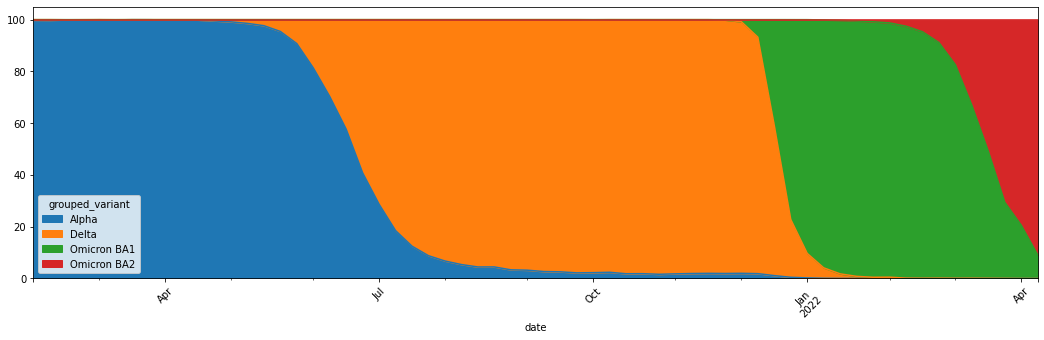

In [24]:
pivot.plot.area(figsize=(18,5), rot=45)

In [25]:
alpha = .4
delta =  1 - (1 - alpha) * .5
omicron_ba1 = 1 - (1 - delta) * .5
omicron_ba2 = 1 - (1 - omicron_ba1) * .5

In [26]:
def score_variant(variant, percentage):
    if variant == 'Delta':
        return percentage * delta / 100
    if variant == 'Omicron BA1':
        return percentage * omicron_ba1 / 100
    if variant == 'Omicron BA2':
        return percentage * omicron_ba2 / 100
    return percentage * alpha / 100

In [27]:
grouped['score'] = grouped.apply(lambda x: score_variant(x.grouped_variant, x.percentage), axis=1)

In [28]:
date_score = grouped.groupby('date')['score'].sum().reset_index()

In [29]:
date_score.head()

,date,score
0,2021-02-07,0.400579
1,2021-02-14,0.400694
2,2021-02-21,0.400367
3,2021-02-28,0.400372
4,2021-03-07,0.400113


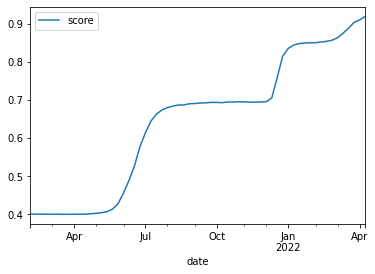

In [30]:
date_score.plot(x='date', y='score')

In [31]:
date_score.to_csv('prob_spread.csv')

In [32]:
result_df.variant.unique()

array(['VOI Epsilon GH/452R.V1 (B.1.429+B.1.427) first detected in USA/California',
       'VOC Alpha GRY (B.1.1.7+Q.*) first detected in the UK',
       'VOI Iota GH/253G.V1 (B.1.526) first detected in USA/New York',
       'VOI Zeta GR/484K.V2 (P.2) first detected in Brazil',
       'VOI Eta G/484K.V3 (B.1.525) first detected in UK/Nigeria',
       'VOC Beta GH/501Y.V2 (B.1.351+B.1.351.2+B.1.351.3) first detected in South Africa',
       'VOI Lambda GR/452Q.V1 (C.37+C.37.1) first detected in Peru',
       'VOC Gamma GR/501Y.V3 (P.1+P.1.*) first detected in Brazil/Japan',
       'VOC Delta GK (B.1.617.2+AY.*) first detected in India', nan,
       'VOI Kappa G/452R.V3 (B.1.617.1) first detected in India',
       'VOI Theta GR/1092K.V1 (P.3) first detected in the Philippines',
       'VOI Mu GH (B.1.621+B.1.621.1) first detected in Colombia',
       'VUM GH/490R (B.1.640+B.1.640.*) first detected in Congo/France',
       'VOC Omicron GRA (B.1.1.529+BA.*) first detected in Botswana/Hong 

In [33]:
result_df.lineage.unique()

array([nan, 'B.1.1.7', 'Q.3', 'Q.4', 'B.1.351', 'C.37', 'P.1',
       'B.1.617.2', 'AY.44', 'AY.103', 'B.1.1.318', 'P.1.10', 'AY.54',
       'AY.43', 'AY.39', 'BA.1.1', 'P.1.17', 'P.1.13', 'P.1.1', 'AY.25',
       'AY.120.1', 'BA.1.16', 'P.1.15', 'P.1.12', 'B.1.351.3',
       'B.1.351.2', 'C.37.1', 'B.1.621', 'BA.1.1.8', 'BA.1.1.7', 'Q.1',
       'P.1.14', 'P.1.2', 'P.1.16', 'AY.48', 'AY.38', 'AY.13', 'Q.8',
       'AY.112', 'AY.26', 'AY.25.1', 'AY.2', 'AY.14', 'AY.122', 'Q.6',
       'P.1.7', 'AY.16', 'AY.75', 'AY.100', 'AY.9', 'AY.36.1', 'AY.120',
       'AY.118', 'B.1.621.1', 'P.1.11', 'AY.10', 'AY.20', 'AY.129',
       'AY.110', 'AY.64', 'AY.102', 'AY.99', 'AY.3', 'AY.126', 'AY.83',
       'AY.55', 'AY.30', 'AY.127', 'AY.121', 'AY.1', 'AY.49', 'AY.62',
       'AY.119', 'AY.106', 'AY.81', 'AY.77', 'AY.67', 'AY.5', 'AY.47',
       'AY.4.7', 'AY.117', 'AY.113', 'P.1.7.1', 'AY.111', 'AY.95',
       'AY.92', 'AY.74', 'AY.69', 'AY.56', 'AY.51', 'AY.125', 'AY.105',
       'AY.101', 'P.1.1

In [34]:
result_df[result_df.lineage.str.startswith('AY.', na=False)].lineage.unique()

array(['AY.44', 'AY.103', 'AY.54', 'AY.43', 'AY.39', 'AY.25', 'AY.120.1',
       'AY.48', 'AY.38', 'AY.13', 'AY.112', 'AY.26', 'AY.25.1', 'AY.2',
       'AY.14', 'AY.122', 'AY.16', 'AY.75', 'AY.100', 'AY.9', 'AY.36.1',
       'AY.120', 'AY.118', 'AY.10', 'AY.20', 'AY.129', 'AY.110', 'AY.64',
       'AY.102', 'AY.99', 'AY.3', 'AY.126', 'AY.83', 'AY.55', 'AY.30',
       'AY.127', 'AY.121', 'AY.1', 'AY.49', 'AY.62', 'AY.119', 'AY.106',
       'AY.81', 'AY.77', 'AY.67', 'AY.5', 'AY.47', 'AY.4.7', 'AY.117',
       'AY.113', 'AY.111', 'AY.95', 'AY.92', 'AY.74', 'AY.69', 'AY.56',
       'AY.51', 'AY.125', 'AY.105', 'AY.101', 'AY.4', 'AY.39.1',
       'AY.98.1', 'AY.9.2', 'AY.35', 'AY.34.1.1', 'AY.15', 'AY.52',
       'AY.107', 'AY.114', 'AY.46', 'AY.45', 'AY.24', 'AY.53', 'AY.3.1',
       'AY.37', 'AY.86', 'AY.65', 'AY.46.4', 'AY.4.6', 'AY.23', 'AY.116',
       'AY.33', 'AY.4.5', 'AY.122.4', 'AY.124', 'AY.91', 'AY.78', 'AY.76',
       'AY.5.3', 'AY.36', 'AY.131', 'AY.119.2', 'AY.11', 'AY.116.

In [35]:
ay_df = result_df[result_df.lineage.str.startswith('AY.', na=False)]

In [36]:
grouped_ay = ay_df.groupby(['date', 'lineage'])['lineage_count'].sum().reset_index()

In [37]:
grouped_ay['percentage'] = grouped_ay.groupby('date')['lineage_count'].apply(lambda x:100 * x / float(x.sum()))

In [38]:
grouped_ay = grouped_ay[grouped_ay.lineage_count > 5]

In [39]:
pivot_ay = grouped_ay.pivot(index='date', columns='lineage', values='percentage')

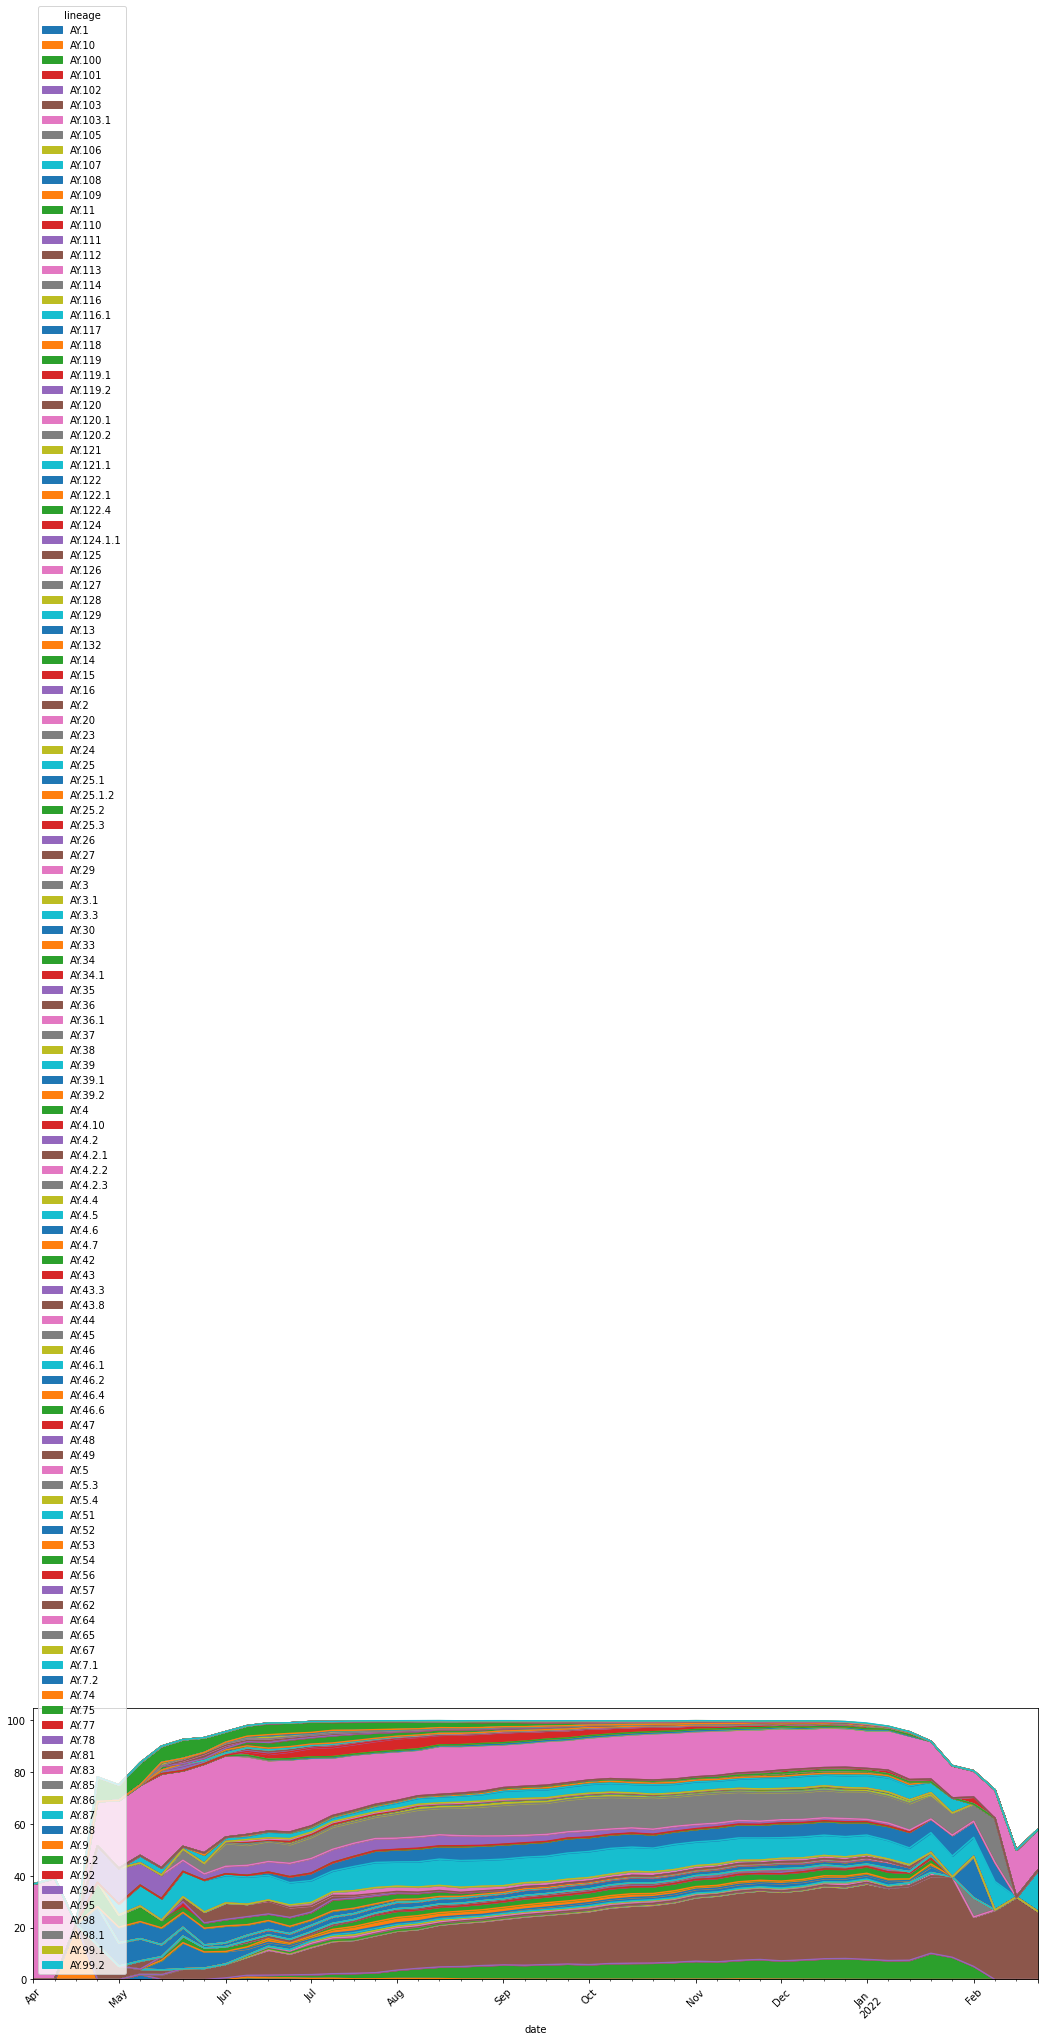

In [40]:
pivot_ay.plot.area(figsize=(18,5), rot=45)